In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, balanced_accuracy_score



In [176]:
df = pd.read_csv('../../2-cleaning-EDA/data/pros.csv')

In [177]:
df.shape

(958, 48)

In [178]:
df.drop(columns = ['Unnamed: 0',
                   'mvp',
                   'taken',
                   'goals',
                   'assists',
                   'avg_distance_to_ball_possession',
                   'shots',
                   'amount_stolen'
                  ],
                   inplace = True)

In [179]:
df.iloc[0, :]

saves                                         0
score                                       378
bcpm                                  420.76846
avg_amount                                48.78
amount_collected                           2338
amount_collected_big                       1535
amount_collected_small                      803
amount_overfill                             296
amount_used_while_supersonic                389
percent_zero_boost                    12.957797
percent_full_boost                    10.159272
percent_boost_0_25                    33.467205
percent_boost_25_50                   27.739504
percent_boost_50_75                   10.636721
percent_boost_75_100                  28.156569
count_powerslide                             84
avg_powerslide_duration                    0.12
avg_speed_percentage                   66.13043
percent_slow_speed                     47.60705
percent_boost_speed                   38.449085
percent_supersonic_speed              13

In [180]:
X = df.drop(columns = 'player_name')
y = df.player_name

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [181]:
y_train.value_counts(normalize = True)

Vati           0.398329
Oski           0.337047
M0nkey M00n    0.264624
Name: player_name, dtype: float64

In [182]:
ss = StandardScaler()

# X_train = pd.DataFrame(ss.fit_transform(X_train), columns = ss.get_feature_names_out())
# X_test = pd.DataFrame(ss.transform(X_test), columns = ss.get_feature_names_out())


In [183]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [184]:
knn.score(X_train, y_train)

0.7785515320334262

In [185]:
knn.score(X_test, y_test)

0.6708333333333333

In [186]:
et = ExtraTreesClassifier()

et.fit(X_train, y_train)


ExtraTreesClassifier()

In [187]:
et.score(X_train, y_train)

1.0

In [188]:
et.score(X_test, y_test)

0.9

In [189]:
poly = PolynomialFeatures(interaction_only=True)

X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out())

In [190]:
X_train_poly.shape

(718, 781)

In [191]:
knn.fit(X_train_poly, y_train)

KNeighborsClassifier()

In [192]:
knn.score(X_train_poly, y_train)

0.7715877437325905

In [193]:
knn.score(X_test_poly, y_test)

0.6875

In [194]:
et.fit(X_train_poly, y_train)

ExtraTreesClassifier()

In [195]:
et.score(X_train_poly, y_train)

1.0

In [196]:
et.score(X_test_poly, y_test)

0.9041666666666667

In [197]:
def get_accuracies(X_train, y_train, X_test, y_test, model, model_name:str, scores_df=None, norm=None, confusion = True):
    
    # Takes training and test splits, a desired model and model name (string),
    # current scoring dataframe and norm parameter for the heatmap output
    
    # Creates columns for scoring metrics on first run
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'bal_acc'])
    
    # fits model to training data
    model.fit(X_train, y_train)
    
    # produces a confusion matrix for the prediction and true values of the test data
    if confusion == True:
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize=norm)
    
    # predicted subreddits for each row, used to calculate balanced accuracy
    preds = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    bal_acc = balanced_accuracy_score(y_test, preds)

    # dataframe updated with model name and corresponding scores
    scores_df.loc[model_name,:] = [train_acc, test_acc, bal_acc]
    
    print(scores_df)
    
    return scores_df

In [198]:
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [199]:
gs_knn = GridSearchCV(
    pipe_knn,
    param_grid={
        'knn__n_neighbors' : [3, 5, 7, 9, 10, 15],
        'knn__weights' : ['uniform', 'distance'],
        'knn__p' : [1, 1.5, 2]
    },
    cv = 3,
    verbose = 1,
    n_jobs = -1,
    scoring='balanced_accuracy'
)

In [200]:
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 10, 15],
                         'knn__p': [1, 1.5, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='balanced_accuracy', verbose=1)

In [201]:
gs_knn.best_params_

{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}

    train_acc test_acc   bal_acc
knn       1.0   0.8625  0.868717


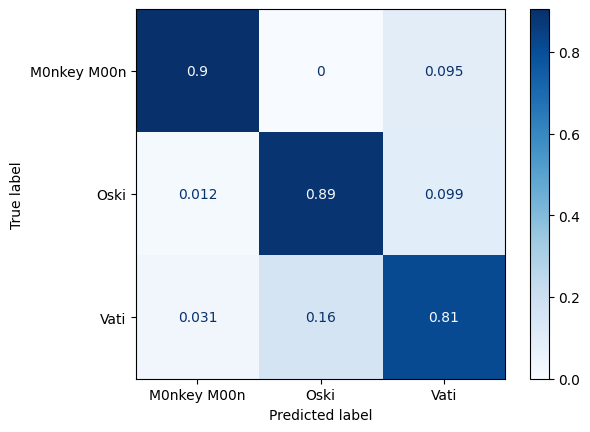

In [202]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           gs_knn.best_estimator_, 
                           'knn',
                           norm = 'true')

In [203]:
pipe_et = Pipeline([
#     ('ss', StandardScaler()),
    ('et', ExtraTreesClassifier())
])

In [204]:
gs_et = GridSearchCV(
    pipe_et,
    param_grid={
        'et__n_estimators' : [46],
        'et__max_depth' : [5,7,10,15],
        'et__min_samples_split' : [1.0, 2,3,4]
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    scoring = 'balanced_accuracy'
)

In [205]:
gs_et.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

In [206]:
gs_et.best_estimator_

Pipeline(steps=[('et', ExtraTreesClassifier(max_depth=10, n_estimators=46))])

    train_acc  test_acc   bal_acc
knn       1.0    0.8625  0.868717
et   0.994429  0.870833  0.868919


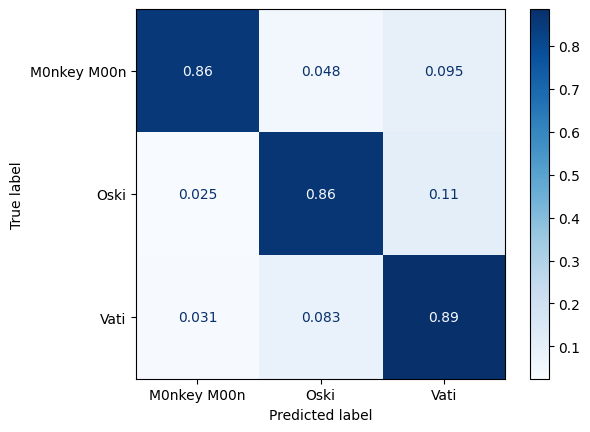

In [207]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           gs_et.best_estimator_, 
                           'et',
                           scores_df = scores_df,
                           norm = 'true')

In [208]:
importances = gs_et.best_estimator_.named_steps['et'].feature_importances_

In [209]:
features = []
for i in range(39):
    features.append((importances[i],df.columns[i]))

In [210]:
features.sort()

In [211]:
features = features[::-1]

In [212]:
feature_importances = pd.DataFrame(features, columns = ['prediction weight', 'stat'])

In [213]:
feature_importances

,prediction weight,stat
0,0.053187,bcpm
1,0.050553,percent_supersonic_speed
2,0.050168,count_powerslide
3,0.046826,avg_speed_percentage
4,0.045591,percent_ground
5,0.044993,avg_amount
6,0.044374,percent_low_air
7,0.043593,percent_full_boost
8,0.043471,percent_slow_speed
9,0.042499,percent_boost_75_100


In [214]:
gs_et.fit(X_train_poly, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

        train_acc  test_acc   bal_acc
knn           1.0    0.8625  0.868717
et       0.994429  0.870833  0.868919
et_poly       1.0  0.916667  0.913966


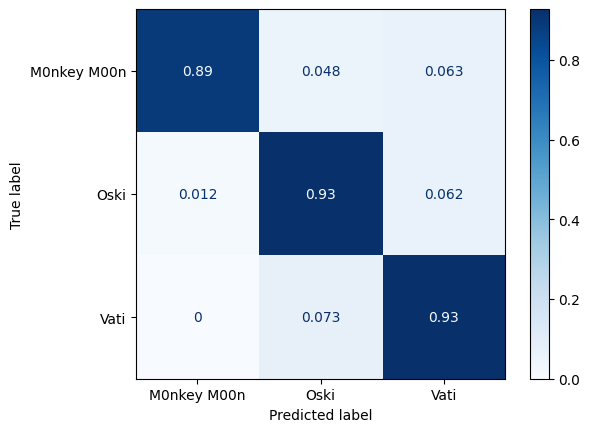

In [215]:
scores_df = get_accuracies(X_train_poly, y_train, X_test_poly, y_test, 
                           gs_et.best_estimator_, 
                           'et_poly',
                           scores_df = scores_df,
                           norm = 'true')

In [216]:
probabilities = pd.DataFrame(gs_et.best_estimator_.predict_proba(X_test_poly), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

In [217]:
probabilities

,MonkeyMoon,Oski,Vatira
0,0.000000,1.000000,0.000000
1,0.021739,0.054853,0.923407
2,0.989130,0.010870,0.000000
3,0.826087,0.065217,0.108696
4,0.793478,0.065217,0.141304
...,...,...,...
235,0.825428,0.000659,0.173913
236,0.966733,0.000659,0.032609
237,0.001976,0.239130,0.758893
238,0.000000,0.934783,0.065217


In [218]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [219]:
mnb.score(X_train, y_train)

0.6044568245125348

In [220]:
mnb.score(X_test, y_test)

0.6333333333333333

In [221]:
pipe_gnb = Pipeline([
    ('ss', StandardScaler()),
    ('gnb', GaussianNB())
])

In [222]:
gs_gnb = GridSearchCV(
    pipe_gnb,
    param_grid = {
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    scoring = 'balanced_accuracy'
)

In [223]:
gs_gnb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('gnb', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='balanced_accuracy', verbose=1)

        train_acc  test_acc   bal_acc
knn           1.0    0.8625  0.868717
et       0.994429  0.870833  0.868919
et_poly       1.0  0.916667  0.913966
gnb      0.779944     0.725  0.740649


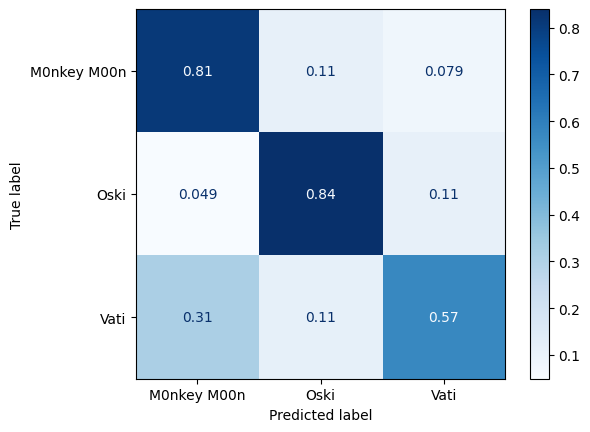

In [224]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           gs_gnb.best_estimator_, 
                           'gnb',
                           scores_df = scores_df,
                           norm = 'true')

In [225]:
stack = [
#     ('gnb', gs_gnb.best_estimator_),
    ('knn', gs_knn.best_estimator_)
]

stx = StackingClassifier(
    estimators=stack,
    final_estimator=gs_et.best_estimator_
)

        train_acc  test_acc   bal_acc
knn           1.0    0.8625  0.868717
et       0.994429  0.870833  0.868919
et_poly       1.0  0.916667  0.913966
gnb      0.779944     0.725  0.740649
stack         1.0  0.833333  0.837559


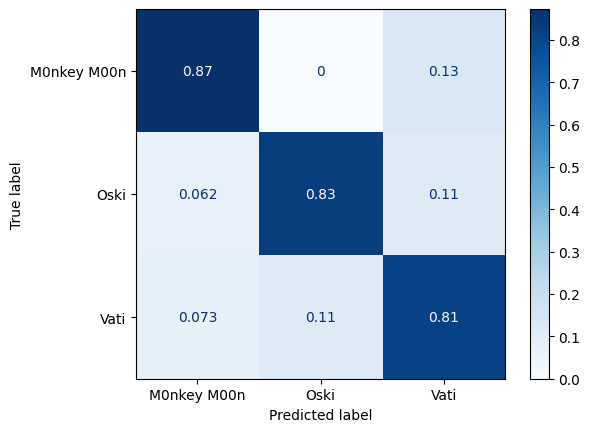

In [226]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           stx, 
                           'stack',
                           scores_df = scores_df,
                           norm = 'true')

In [227]:
gs_knn.fit(X_train_poly, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 10, 15],
                         'knn__p': [1, 1.5, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='balanced_accuracy', verbose=1)

In [228]:
gs_et.fit(X_train_poly, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

In [229]:
stack = [
#     ('gnb', gs_gnb.best_estimator_),
    ('knn', gs_knn.best_estimator_)
]

stx = StackingClassifier(
    estimators=stack,
    final_estimator=gs_et.best_estimator_
)

In [230]:
stx.fit(X_train, y_train)

StackingClassifier(estimators=[('knn',
                                Pipeline(steps=[('ss', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('et',
                                                    ExtraTreesClassifier(max_depth=15,
                                                                         min_samples_split=4,
                                                                         n_estimators=46))]))

In [231]:
stx.fit(X_train_poly, y_train)

StackingClassifier(estimators=[('knn',
                                Pipeline(steps=[('ss', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('et',
                                                    ExtraTreesClassifier(max_depth=15,
                                                                         min_samples_split=4,
                                                                         n_estimators=46))]))

           train_acc  test_acc   bal_acc
knn              1.0    0.8625  0.868717
et          0.994429  0.870833  0.868919
et_poly          1.0  0.916667  0.913966
gnb         0.779944     0.725  0.740649
stack            1.0  0.833333  0.837559
stack_poly       1.0  0.879167  0.882716


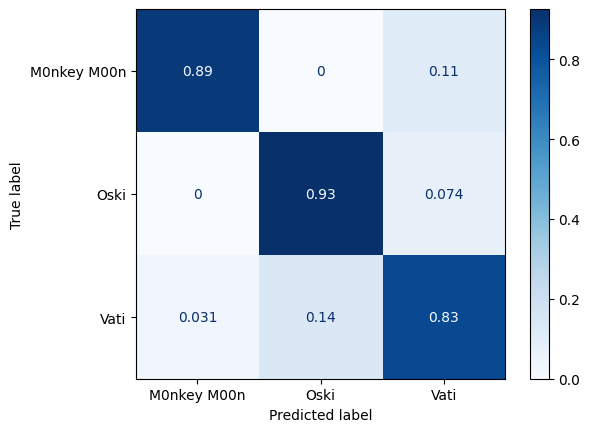

In [232]:
scores_df = get_accuracies(X_train_poly, y_train, X_test_poly, y_test, 
                           stx, 
                           'stack_poly',
                           scores_df = scores_df,
                           norm = 'true'
                           )

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [234]:
nn_y = y.replace({
    'M0nkey M00n' : 0,
    'Oski' : 1,
    'Vati' : 2
})

In [235]:
nn_y.value_counts()

2    382
1    323
0    253
Name: player_name, dtype: int64

In [236]:
nn_y = to_categorical(nn_y)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, nn_y, random_state=42, stratify=y)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [238]:
model = Sequential()

model.add(Dense(32,
                input_shape = (39,),
                activation = 'relu'
               )
         )

model.add(Dense(16,
                activation='relu'
               )
         )

model.add(Dense(8,
                activation='relu'
               )
         )

model.add(Dense(3,
                activation = 'softmax'
               )
         )

In [239]:
model.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [240]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience = 20,
                           min_delta = 0.00,
                           restore_best_weights=True
                          )

In [241]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs = 150, 
          batch_size = 512,
          callbacks = [early_stop]
                   )

Epoch 1/150
2/2 [==============================] - 3s 351ms/step - loss: 1.1974 - acc: 0.2855 - val_loss: 1.1796 - val_acc: 0.2875
Epoch 2/150
2/2 [==============================] - 0s 67ms/step - loss: 1.1634 - acc: 0.3008 - val_loss: 1.1466 - val_acc: 0.3417
Epoch 3/150
2/2 [==============================] - 0s 55ms/step - loss: 1.1341 - acc: 0.3370 - val_loss: 1.1172 - val_acc: 0.3750
Epoch 4/150
2/2 [==============================] - 0s 52ms/step - loss: 1.1076 - acc: 0.3691 - val_loss: 1.0905 - val_acc: 0.4083
Epoch 5/150
2/2 [==============================] - 0s 56ms/step - loss: 1.0827 - acc: 0.4039 - val_loss: 1.0673 - val_acc: 0.4458
Epoch 6/150
2/2 [==============================] - 0s 66ms/step - loss: 1.0606 - acc: 0.4164 - val_loss: 1.0465 - val_acc: 0.4875
Epoch 7/150
2/2 [==============================] - 0s 67ms/step - loss: 1.0414 - acc: 0.4708 - val_loss: 1.0285 - val_acc: 0.5458
Epoch 8/150
2/2 [==============================] - 0s 56ms/step - loss: 1.0231 - acc: 0.5

2/2 [==============================] - 0s 66ms/step - loss: 0.4210 - acc: 0.8774 - val_loss: 0.5270 - val_acc: 0.8417
Epoch 64/150
2/2 [==============================] - 0s 78ms/step - loss: 0.4126 - acc: 0.8802 - val_loss: 0.5219 - val_acc: 0.8417
Epoch 65/150
2/2 [==============================] - 0s 64ms/step - loss: 0.4043 - acc: 0.8844 - val_loss: 0.5175 - val_acc: 0.8417
Epoch 66/150
2/2 [==============================] - 0s 59ms/step - loss: 0.3965 - acc: 0.8858 - val_loss: 0.5129 - val_acc: 0.8417
Epoch 67/150
2/2 [==============================] - 0s 63ms/step - loss: 0.3880 - acc: 0.8914 - val_loss: 0.5088 - val_acc: 0.8417
Epoch 68/150
2/2 [==============================] - 0s 51ms/step - loss: 0.3796 - acc: 0.8955 - val_loss: 0.5051 - val_acc: 0.8417
Epoch 69/150
2/2 [==============================] - 0s 50ms/step - loss: 0.3714 - acc: 0.8942 - val_loss: 0.5015 - val_acc: 0.8417
Epoch 70/150
2/2 [==============================] - 0s 55ms/step - loss: 0.3632 - acc: 0.8955 - 

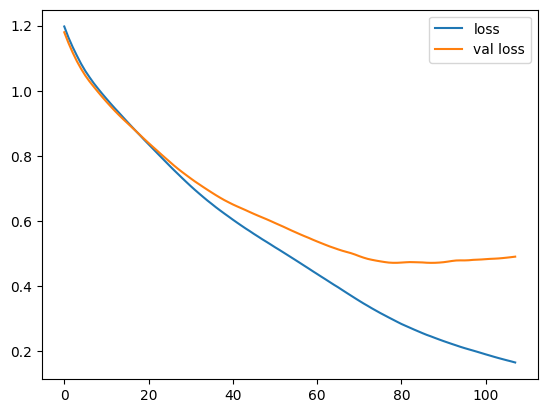

In [242]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend();

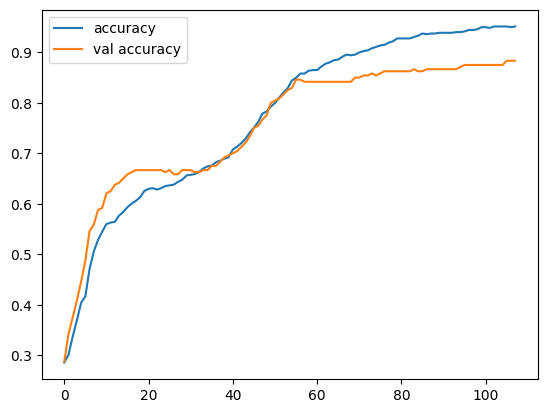

In [243]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'val accuracy')
plt.legend();

In [245]:
model.evaluate(X_test, y_test)[1]

8/8 [==============================] - 0s 3ms/step - loss: 0.4716 - acc: 0.8667


0.8666666746139526

In [246]:
nn_predictions = pd.DataFrame(model.predict(X_test), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

8/8 [==============================] - 0s 2ms/step


In [247]:
nn_predictions

,MonkeyMoon,Oski,Vatira
0,0.001189,0.995867,0.002944
1,0.211776,0.016098,0.772127
2,0.843742,0.104289,0.051969
3,0.533325,0.427790,0.038885
4,0.764749,0.048661,0.186590
...,...,...,...
235,0.949494,0.006995,0.043512
236,0.804739,0.127808,0.067452
237,0.002075,0.031660,0.966265
238,0.033327,0.764976,0.201697


In [248]:
probabilities

,MonkeyMoon,Oski,Vatira
0,0.000000,1.000000,0.000000
1,0.021739,0.054853,0.923407
2,0.989130,0.010870,0.000000
3,0.826087,0.065217,0.108696
4,0.793478,0.065217,0.141304
...,...,...,...
235,0.825428,0.000659,0.173913
236,0.966733,0.000659,0.032609
237,0.001976,0.239130,0.758893
238,0.000000,0.934783,0.065217


In [249]:
import os
import pickle

In [250]:
# with open('nn_model.pkl', 'wb') as picklefile:
#     pickle.dump(model, picklefile)

In [251]:
# model.save('tf_save_model')

In [252]:
with open('et_model.pkl', 'wb') as picklefile:
    pickle.dump(gs_et.best_estimator_, picklefile)

In [253]:
boay = pd.read_csv('../data/boay_.csv')

In [264]:
boay_predictions = pd.DataFrame(model.predict(boay.drop(columns = ['Unnamed: 0','player_name']),
                                             ), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

1/1 [==============================] - 0s 28ms/step


In [265]:
boay_predictions

,MonkeyMoon,Oski,Vatira
0,0.0,0.0,9.999999e-01
1,0.0,0.0,9.999999e-01
2,0.0,0.0,9.999999e-01
3,0.0,0.0,9.999999e-01
4,0.0,0.0,9.999999e-01
5,0.0,0.0,9.999999e-01
6,0.0,0.0,9.999999e-01
7,0.0,0.0,9.999999e-01
8,0.0,0.0,9.999999e-01
9,0.0,0.0,9.999999e-01
